# Advancing Rare-Earth Separation by Machine Learning


This is the code reproduce for paper, [Liu, T., Johnson, K.R., Jansone-Popova, S. and Jiang, D.E., 2022. Advancing Rare-Earth Separation by Machine Learning. JACS Au, 2(6), pp.1428-1434.](https://pubs.acs.org/doi/full/10.1021/jacsau.2c00122)

Dr. Schrier has exploration of how to improve the performance: \
See [his blog](https://www.wolframcloud.com/obj/jschrier0/Published/2023.11.30_towards_better_ML.nb).\

We use keras_tuner to tune the hyperparamers to improve the performance:\
[A YouTube video tutorial](https://www.youtube.com/watch?v=vvC15l4CY1Q)\
[The official keras_tuner doc](https://keras.io/guides/keras_tuner/getting_started/)


# Load dataset

In [1]:
# import packages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

print("tf version: ", tf.__version__)
print("keras version: ", keras.__version__)
print("np version: ", np.__version__)
print("matplotlib version: ", matplotlib.__version__)
print("pd version: ", pd.__version__)

tf version:  2.17.0
keras version:  3.4.1
np version:  1.26.4
matplotlib version:  3.8.0
pd version:  2.1.4


In [2]:
# Read the excel file

dataset_path = "../au2c00122_si_002.xlsx"
train_dataset = pd.read_excel(dataset_path, sheet_name='training set')
val_dataset = pd.read_excel(dataset_path, sheet_name='validation set')

val_dataset.head()

,ECFP-1,ECFP-2,ECFP-3,ECFP-4,ECFP-5,ECFP-6,ECFP-7,ECFP-8,ECFP-9,ECFP-10,...,Second IE_metal (kJ/mol),Third IE_metal (kJ/mol),Electron Affinity_metal (kJ/mol),Atomic Radius_metal,Covalent Radius_metal,Pauling EN_metal,Ionic Radius_metal,Standard Entropy_metal (J/mol.K),log_D,reference
0,0,0,0,0,0,0,0,0,0,0,...,1341.1,2022.3,32.8,2.24,1.74,1.00,0.861,51.0,0.342423,1
1,0,0,0,0,0,0,0,0,0,0,...,1068.1,2257.8,15.6,2.36,1.85,1.17,0.958,69.5,0.505150,1
2,0,0,0,0,0,0,0,0,0,0,...,1166.5,1990.5,13.2,2.34,1.82,1.20,0.938,67.9,0.230449,1
3,0,0,0,0,0,0,0,0,0,0,...,1034.3,2132.3,184.9,2.39,1.88,1.14,0.983,71.1,0.041393,1
4,0,0,0,0,0,0,0,0,0,0,...,1034.3,2132.3,184.9,2.39,1.88,1.14,0.983,71.1,1.344392,2


# Data preparation

In [3]:
# Split x and y
x_train_df = train_dataset.iloc[:, 0:2291]
y_train_df = train_dataset.iloc[:, 2291]
x_val_df = val_dataset.iloc[:, 0:2291]
y_val_df = val_dataset.iloc[:, 2291]

# Convert df to numpy array
x_train = x_train_df.to_numpy()
y_train = y_train_df.to_numpy()
x_val = x_val_df.to_numpy()
y_val = y_val_df.to_numpy()

print(x_train[0])
print(y_train[0])
print(x_train.shape)

[ 0.    0.    0.   ...  1.1   1.03 56.9 ]
0.477121255
(1085, 2291)


# Build and train the model (traditional)

In [5]:
# Build the model (sequential)
model = keras.models.Sequential()
model.add(keras.layers.Input([2291]))
model.add(keras.layers.Dense(512, kernel_initializer='normal', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.PReLU())
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(128, kernel_initializer='normal', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.PReLU())
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(16, kernel_initializer='normal', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.PReLU())
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(1, kernel_initializer='normal'))

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss="mean_absolute_error", optimizer=optimizer, metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.R2Score()])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 512)                 │       1,173,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_3 (PReLU)                    │ (None, 512)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_4 (PReLU)                    │ (None, 128)                 │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_5 (PReLU)                    │ (None, 16)                  │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,241,905 (4.74 MB)

 Trainable params: 1,241,905 (4.74 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train the model
history = model.fit(x_train, y_train, epochs=15000, validation_data=[x_val, y_val])

Epoch 1/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 52.9861 - r2_score: -502.0702 - root_mean_squared_error: 30.6475 - val_loss: 39.4940 - val_r2_score: -51.4682 - val_root_mean_squared_error: 9.8748
Epoch 2/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 51.5364 - r2_score: -455.6333 - root_mean_squared_error: 28.8672 - val_loss: 35.7699 - val_r2_score: -21.0010 - val_root_mean_squared_error: 6.3944
Epoch 3/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 48.8272 - r2_score: -365.1946 - root_mean_squared_error: 26.0170 - val_loss: 33.6356 - val_r2_score: -9.0535 - val_root_mean_squared_error: 4.3225
Epoch 4/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 47.0447 - r2_score: -309.1114 - root_mean_squared_error: 24.3543 - val_loss: 32.1763 - val_r2_score: -3.8282 - val_root_mean_squared_error: 2.9955
Epoch 5/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 44.6002 - r2_score: -232.1978 - root_mean_squared_error: 21.1030 - val_loss: 31.3428 - val_r2_score:

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.5575 - r2_score: 0.7526 - root_mean_squared_error: 0.6855 - val_loss: 0.5268 - val_r2_score: 0.7442 - val_root_mean_squared_error: 0.6894
Epoch 5533/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.5818 - r2_score: 0.7264 - root_mean_squared_error: 0.7089 - val_loss: 0.5327 - val_r2_score: 0.7438 - val_root_mean_squared_error: 0.6900
Epoch 5534/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.5670 - r2_score: 0.7565 - root_mean_squared_error: 0.6796 - val_loss: 0.5267 - val_r2_score: 0.7505 - val_root_mean_squared_error: 0.6810
Epoch 5535/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.5541 - r2_score: 0.7714 - root_mean_squared_error: 0.6703 - val_loss: 0.5330 - val_r2_score: 0.7379 - val_root_mean_squared_error: 0.6979
Epoch 5536/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.5497 - r2_score: 0.7559 - root_mean_squared_error: 0.6614 - val_loss: 0.5355 - val_r2_score: 0.7432 - val_root_mean_squared_error:

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5865 - r2_score: 0.7296 - root_mean_squared_error: 0.7126 - val_loss: 0.5174 - val_r2_score: 0.7490 - val_root_mean_squared_error: 0.6830
Epoch 5701/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5614 - r2_score: 0.7324 - root_mean_squared_error: 0.7032 - val_loss: 0.5210 - val_r2_score: 0.7476 - val_root_mean_squared_error: 0.6849
Epoch 5702/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5786 - r2_score: 0.7214 - root_mean_squared_error: 0.7080 - val_loss: 0.5275 - val_r2_score: 0.7439 - val_root_mean_squared_error: 0.6899
Epoch 5703/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.5530 - r2_score: 0.7502 - root_mean_squared_error: 0.6761 - val_loss: 0.5286 - val_r2_score: 0.7430 - val_root_mean_squared_error: 0.6911
Epoch 5704/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.5678 - r2_score: 0.7344 - root_mean_squared_error: 0.6883 - val_loss: 0.5300 - val_r2_score: 0.7379 - val_root_mean_squared_error:

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.5150 - r2_score: 0.7877 - root_mean_squared_error: 0.6351 - val_loss: 0.4798 - val_r2_score: 0.7940 - val_root_mean_squared_error: 0.6188
Epoch 6657/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5280 - r2_score: 0.7780 - root_mean_squared_error: 0.6321 - val_loss: 0.4916 - val_r2_score: 0.7803 - val_root_mean_squared_error: 0.6390
Epoch 6658/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5311 - r2_score: 0.7843 - root_mean_squared_error: 0.6410 - val_loss: 0.4965 - val_r2_score: 0.7791 - val_root_mean_squared_error: 0.6407
Epoch 6659/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5382 - r2_score: 0.7647 - root_mean_squared_error: 0.6586 - val_loss: 0.4885 - val_r2_score: 0.7865 - val_root_mean_squared_error: 0.6299
Epoch 6660/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.5596 - r2_score: 0.7309 - root_mean_squared_error: 0.6809 - val_loss: 0.4753 - val_r2_score: 0.7970 - val_root_mean_squared_error:

In [8]:
# Save the model
model_name = "trained_model.keras"
model.save(model_name)

# Build and train the model (keras_tuner)

In [7]:
# build the model and define the search space using argument hp

def build_model(hp):
    model = keras.models.Sequential()

    # Input layer
    model.add(keras.layers.Input([2291]))
    
    # Define activation choice for all hidden layer
    activation_choice=hp.Choice("activation_all_layer", ["prelu", "relu", "tanh", "softmax"])

    # 1st layer
    if activation_choice == "prelu":
        model.add(keras.layers.Dense(
            # Tune number of units. 
            units=hp.Int("units", min_value=384, max_value=640, step=128),
            kernel_initializer='normal',
            # Set l2 weigh decay as 0.01
            kernel_regularizer=keras.regularizers.l2(0.01)
        ))
        model.add(keras.layers.PReLU())  # Add PReLU as a separate layer
    else:
        model.add(keras.layers.Dense(
            units=hp.Int("units", min_value=384, max_value=640, step=128),
            activation=activation_choice,
            kernel_initializer='normal',
            kernel_regularizer=keras.regularizers.l2(0.01)
        ))
    # Tune dropout rate.
    dropout_choise=hp.Choice("dropout_rate", [0.25, 0.5, 0.75])
    model.add(keras.layers.Dropout(rate=dropout_choise))
    
    # 2nd layer
    if activation_choice == "prelu":
        model.add(keras.layers.Dense(
            # Tune number of units. 
            128, 
            kernel_initializer='normal',
            # Set l2 weigh decay as 0.01
            kernel_regularizer=keras.regularizers.l2(0.01)
        ))
        model.add(keras.layers.PReLU())  # Add PReLU as a separate layer
    else:
        model.add(keras.layers.Dense(
            128, 
            activation=activation_choice,
            kernel_initializer='normal',
            kernel_regularizer=keras.regularizers.l2(0.01)
        ))
    # Tune dropout rate.
    model.add(keras.layers.Dropout(rate=dropout_choise))
    
    # 3rd layer
    if activation_choice == "prelu":
        model.add(keras.layers.Dense(
            # Tune number of units. 
            16,
            kernel_initializer='normal',
            # Set l2 weigh decay as 0.01
            kernel_regularizer=keras.regularizers.l2(0.01)
        ))
        model.add(keras.layers.PReLU())  # Add PReLU as a separate layer
    else:
        model.add(keras.layers.Dense(
            16,
            activation=activation_choice,
            kernel_initializer='normal',
            kernel_regularizer=keras.regularizers.l2(0.01)
        ))
    # Tune dropout rate.
    model.add(keras.layers.Dropout(rate=dropout_choise))
    
    # output layer
    model.add(keras.layers.Dense(1, kernel_initializer='normal'))
    
    # Compile the model
    # Define the optimizer choice and learning rate choise
    optimizer_choice = hp.Choice("optimizer", ["adam", "sgd", "rmsprop"])
    # lr_choice=hp.Choice("lr", values=[1e-6, 1e-5, 1e-4])
    if optimizer_choice == "adam":
        optimizer = keras.optimizers.Adam(
            learning_rate= 1e-5
        )
    elif optimizer_choice == "sgd":
        optimizer = keras.optimizers.SGD(
            learning_rate=1e-5
        )
    elif optimizer_choice == "rmsprop":
        optimizer = keras.optimizers.RMSprop(
            learning_rate=1e-5
        )
    
    model.compile(loss="mean_absolute_error", optimizer=optimizer, metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.R2Score()])

    return model

In [8]:
import keras_tuner

print("keras_tuner version:", keras_tuner.__version__)

keras_tuner version: 1.4.7


In [9]:
# Init the tuner
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective=keras_tuner.Objective(name="val_r2_score", direction="max"),
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
    directory="models_dir",
    project_name="SepaML_Project",
)

# Print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 4
activation_all_layer (Choice)
{'default': 'prelu', 'conditions': [], 'values': ['prelu', 'relu', 'tanh', 'softmax'], 'ordered': False}
units (Int)
{'default': None, 'conditions': [], 'min_value': 384, 'max_value': 640, 'step': 128, 'sampling': 'linear'}
dropout_rate (Choice)
{'default': 0.25, 'conditions': [], 'values': [0.25, 0.5, 0.75], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd', 'rmsprop'], 'ordered': False}


In [ ]:
# Start the search
tuner.search(x_train, y_train, epochs=15000, validation_data=(x_val, y_val))


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
softmax           |softmax           |activation_all_layer
512               |512               |units
0.25              |0.25              |dropout_rate
sgd               |sgd               |optimizer


Epoch 1/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 31.9916 - r2_score: -0.0285 - root_mean_squared_error: 1.3559 - val_loss: 32.0475 - val_r2_score: -0.0765 - val_root_mean_squared_error: 1.4144
Epoch 2/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 32.0643 - r2_score: -0.0682 - root_mean_squared_error: 1.4266 - val_loss: 32.0470 - val_r2_score: -0.0765 - val_root_mean_squared_error: 1.4144
Epoch 3/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 32.0542 - r2_score: -0.0369 - root_mean_squared_error: 1.4054 - val_loss: 32.0466 - val_r2_score: -0.0764 - val_root_mean_squared_error: 1.4144
Epoch 4/15000
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 32.0006 - r2_score: -0.0295 - root_m

In [ ]:
# Query the results

# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
# Print the best model
best_model = models[0]
best_model.summary()

In [56]:
# Print a summary of the search results.
tuner.results_summary()

Results summary
Results in models_dir\SepaML_Project
Showing 10 best trials
Objective(name="val_r2_score", direction="max")

Trial 03 summary
Hyperparameters:
dropout: True
units: 512
activation_1st_layer: tanh
activation_2nd_layer: tanh
lr: 2.4835842855029617e-06
Score: -0.05992025136947632

Trial 09 summary
Hyperparameters:
dropout: False
units: 512
activation_1st_layer: tanh
activation_2nd_layer: tanh
lr: 4.377992596146039e-06
Score: -0.06808924674987793

Trial 00 summary
Hyperparameters:
dropout: False
units: 768
activation_1st_layer: softmax
activation_2nd_layer: softmax
lr: 3.035371750428452e-05
Score: -0.06967204809188843

Trial 05 summary
Hyperparameters:
dropout: False
units: 1024
activation_1st_layer: tanh
activation_2nd_layer: softmax
lr: 5.27081015449596e-06
Score: -0.06975317001342773

Trial 01 summary
Hyperparameters:
dropout: True
units: 768
activation_1st_layer: softmax
activation_2nd_layer: softmax
lr: 2.6992543832419778e-06
Score: -0.06982278823852539

Trial 07 summar

# Evaluate the model

In [9]:
# Load the best saved model

model_name = "trained_model.keras"
loaded_model = keras.models.load_model(model_name)

In [10]:
# Evaluate trained model

results = model.evaluate(x_train, y_train, batch_size=128)
results = model.evaluate(x_val, y_val, batch_size=128)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3233 - r2_score: 0.8938 - root_mean_squared_error: 0.4207
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.3893 - r2_score: 0.8571 - root_mean_squared_error: 0.5154


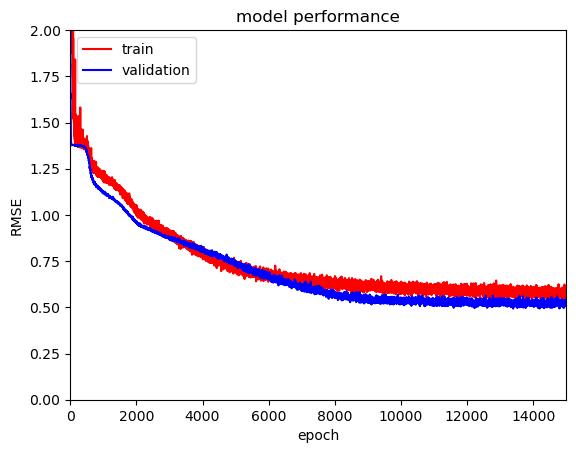

In [13]:
# plot performance vs epoch

plt.plot(history.history['root_mean_squared_error'],'r')
plt.plot(history.history['val_root_mean_squared_error'],'b')
plt.title('model performance')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.xlim([0, 15000])
plt.ylim([0, 2])
plt.show()

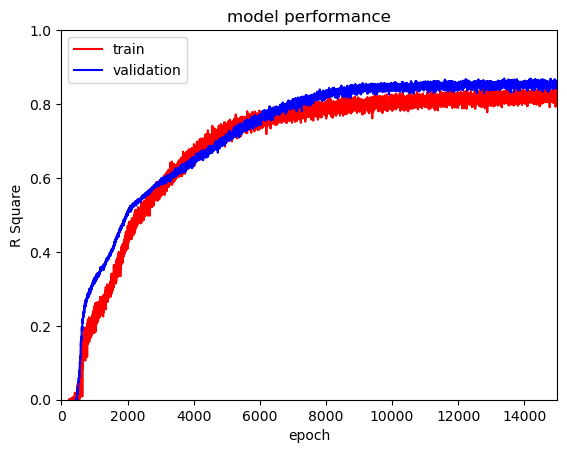

In [14]:
# plot performance vs epoch

plt.plot(history.history['r2_score'],'r')
plt.plot(history.history['val_r2_score'],'b')
plt.title('model performance')
plt.ylabel('R Square')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.xlim([0, 15000])
plt.ylim([0, 1])
plt.show()

# Inference

In [ ]:
# predict using the loaded model

# y_pred_train = model.predict(X_Train_arr)
# print(y_pred_train)

# y_pred_val = model.predict(X_Validation_arr)
# print(y_pred_val)